In [2]:
import pandas as pd
import os
import sys
import win32cred
import requests
from datetime import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from eodhd import APIClient
from ticker_loader import load_SPY_components
import sqlite3
from tqdm import tqdm
import time 
import pickle
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from SQLite_tools import query_stock_data

In [3]:
stocks = query_stock_data(table="Stocks")
stocks

,Ticker,Name,Currency,Sector,Industry,IPODate,FiscalYearEnd
0,HMA,Heartland Media Acquisition Corp.,USD,Financials,Investment Holding Companies,2022-03-14,December
1,PH,Parker-Hannifin Corporation,USD,Industrials,Specialty Industrial Machinery,1985-07-01,June
2,CMS,CMS Energy Corporation,USD,Utilities,Utilities - Regulated Electric,1984-12-31,December
3,OI,O-I Glass Inc,USD,Consumer Cyclical,Packaging & Containers,1991-12-11,December
4,LDG,Longs Drug Stores Corp,USD,Other,Other,None,None
...,...,...,...,...,...,...,...
1087,CNG,Consolidated Natural Gas Co,USD,Other,Other,None,None
1088,YRCW,Yellow Corporation,USD,Industrials,Trucking,1986-07-09,December
1089,LVLT,Level 3 Communications Inc,USD,Other,Other,1986-10-17,December
1090,UPR,Union Pacific Resources Group Inc,USD,Other,Other,None,None


In [ ]:

industry_summary = stocks.groupby(['Sector', 'Industry'], as_index=False).agg(StockCount=('Ticker', 'count'))

total_stocks = industry_summary['StockCount'].sum()
industry_summary['Percentage'] = (industry_summary['StockCount'] / total_stocks) * 100
industry_summary['Label'] = industry_summary.apply(
    lambda x: f"{x['Industry']}<br>Stocks: {x['StockCount']}<br>Percentage: {x['Percentage']:.2f}%", axis=1)

industry_summary = industry_summary[industry_summary['Industry'] != 'Other']

fig = px.treemap(
    industry_summary,
    path=['Sector', 'Industry'],  
    values='StockCount',          
    color='Sector',              
    hover_data={'StockCount': True, 'Percentage': True},  
    labels={'StockCount': 'Number of Stocks', 'Percentage': 'Percentage'},
    custom_data=['Label']         
)

fig.update_layout(height=1600, width=1000)

fig.update_traces(texttemplate='%{customdata[0]}', textinfo="label+text+value")
fig.update_layout(title='Stocks by Sector and Industry')#, width=1500)
fig.update_layout(title_font_size=24)
fig.update_traces(textfont_size=18)

fig.update_layout(margin=dict(l=30, r=30, t=70, b=30, pad=0))
fig.show()

In [ ]:
income_statements = query_stock_data(table="Income_Statements", ticker = "all_stocks", start_date = "1996-01-01", end_date = "2024-07-01")
income_statements = income_statements[["Ticker", "FilingDate", "EffectiveDate", "TotalRevenue", "NetIncome", "GrossProfit", "EBITDA"]]
# income_statements = income_statements[income_statements["EffectiveDate"] > "2019-01-01"]

income_statements["EffectiveDate"] = pd.to_datetime(income_statements["EffectiveDate"])
income_statements = income_statements[income_statements["EffectiveDate"].dt.month == 12].reset_index(drop=True)
income_statements

,Ticker,FilingDate,EffectiveDate,TotalRevenue,NetIncome,GrossProfit,EBITDA
0,TWX,1997-01-01,1996-12-31,409400000.00000000,-154800000.00000000,176500000.00000000,-140700000.00000000
1,COR,1997-01-01,1996-12-31,1746900000.00000000,11800000.00000000,86800000.00000000,32000000.00000000
2,AME,1997-01-01,1996-12-31,204300000.00000000,13100000.00000000,50600000.00000000,31400000.00000000
3,AMZN,1997-01-01,1996-12-31,8400000.00000000,-2300000.00000000,-3400000.00000000,-12600000.00000000
4,DXC,1997-01-01,1996-12-31,1421600000.00000000,57400000.00000000,308800000.00000000,183600000.00000000
...,...,...,...,...,...,...,...
17853,APTV,2024-03-29,2023-12-31,4919000000.00000000,905000000.00000000,922000000.00000000,628000000.00000000
17854,CPWR,2024-03-29,2023-12-31,0.00000000,329805355.00000000,NaN,330382275.00000000
17855,EP,2024-03-29,2023-12-31,9914059.00000000,-4797477.00000000,-328926.00000000,-2816834.00000000
17856,ALB,2024-03-29,2023-12-31,2356165000.00000000,-617680000.00000000,-690683000.00000000,-740691000.00000000


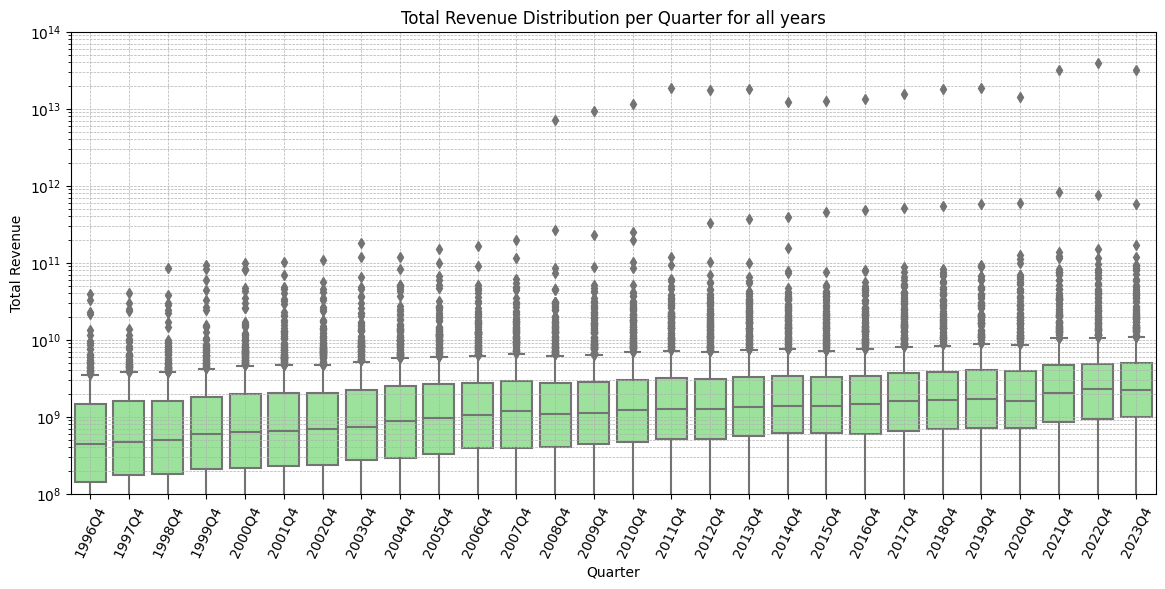

In [ ]:

income_statements['Quarter'] = income_statements['EffectiveDate'].dt.to_period('Q').astype(str)
plt.figure(figsize=(14, 6))

sns.boxplot(x='Quarter', y='TotalRevenue', data=income_statements, color='lightgreen', whis=1.5)

plt.title('Total Revenue Distribution per Quarter for all years')
plt.xlabel('Quarter')
plt.ylabel('Total Revenue')

plt.yscale('log')

plt.ylim(1e8, 1e14)
plt.xticks(rotation=65)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

### Showing the change in Total Revenue over the years

In [ ]:

income_statements['RevenuePctChange'] = income_statements.groupby('Ticker')['TotalRevenue'].pct_change() * 100
income_statements = income_statements.dropna(subset=['RevenuePctChange'])  # Optional: Drop rows with NaN in 'RevenuePctChange'

income_statements['RevenuePctChange'] = income_statements['RevenuePctChange'].replace([float('inf'), float('-inf')], 0)

income_statements

C:\Users\emilh\AppData\Local\Temp\ipykernel_7432\3402118448.py:1: FutureWarning:

The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

C:\Users\emilh\AppData\Local\Temp\ipykernel_7432\3402118448.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Ticker,FilingDate,EffectiveDate,TotalRevenue,NetIncome,GrossProfit,EBITDA,Quarter,RevenuePctChange
402,TWX,1998-01-01,1997-12-31,592000000.00000000,20800000.00000000,235100000.00000000,65800000.00000000,1997Q4,44.60185638
403,COR,1998-01-01,1997-12-31,2254600000.00000000,14500000.00000000,106000000.00000000,40200000.00000000,1997Q4,29.06291144
404,AME,1998-01-01,1997-12-31,217100000.00000000,13600000.00000000,50100000.00000000,31800000.00000000,1997Q4,6.26529613
405,DXC,1998-01-01,1997-12-31,1664100000.00000000,69100000.00000000,362200000.00000000,213900000.00000000,1997Q4,17.05824423
406,BLL,1998-01-01,1997-12-31,574800000.00000000,7800000.00000000,94700000.00000000,42500000.00000000,1997Q4,14.93701260
...,...,...,...,...,...,...,...,...,...
17852,IGT,2024-03-28,2023-12-31,1067000000.00000000,82000000.00000000,537000000.00000000,450000000.00000000,2023Q4,-2.37877402
17853,APTV,2024-03-29,2023-12-31,4919000000.00000000,905000000.00000000,922000000.00000000,628000000.00000000,2023Q4,6.01293103
17855,EP,2024-03-29,2023-12-31,9914059.00000000,-4797477.00000000,-328926.00000000,-2816834.00000000,2023Q4,-10.04985063
17856,ALB,2024-03-29,2023-12-31,2356165000.00000000,-617680000.00000000,-690683000.00000000,-740691000.00000000,2023Q4,-10.10359492


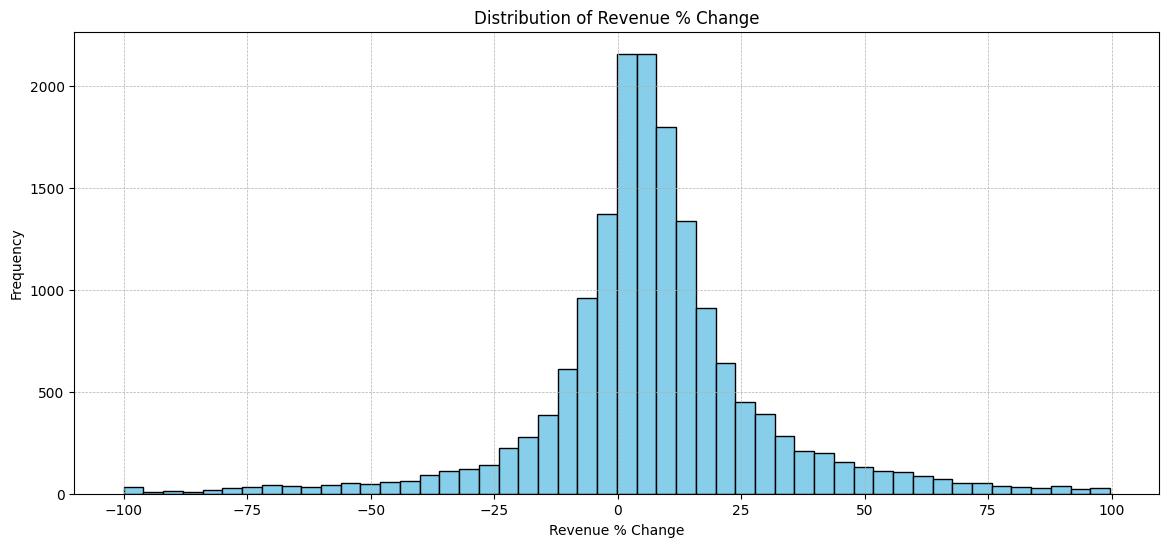

In [ ]:
income_statements_for_viz = income_statements[income_statements['RevenuePctChange'].between(-100, 100)]  # Filter out outliers

plt.figure(figsize=(14, 6))
plt.hist(income_statements_for_viz['RevenuePctChange'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Revenue % Change')
plt.xlabel('Revenue % Change')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [9]:
income_statements_for_viz.describe()

,EffectiveDate,TotalRevenue,NetIncome,GrossProfit,EBITDA,RevenuePctChange
count,15201,15173.00000000,15055.00000000,14533.00000000,13559.00000000,15201.00000000
mean,2011-12-27 00:50:23.801065984,19643313721.97180939,2063735000.42716646,7294729537.88119316,7807297030.59245682,6.00368009
min,1997-12-31 00:00:00,-6342162000.00000000,-6308431000000.00000000,-1203160691000.00000000,-311210000000.00000000,-49.94082840
25%,2005-12-31 00:00:00,509687000.00000000,20732500.00000000,202928000.00000000,84774500.00000000,-1.89599133
50%,2011-12-31 00:00:00,1316000000.00000000,91639000.00000000,537400000.00000000,243700000.00000000,5.67875052
75%,2017-12-31 00:00:00,3308000000.00000000,277225000.00000000,1421700000.00000000,668550000.00000000,14.23822056
max,2023-12-31 00:00:00,39678000000000.00000000,6833872000000.00000000,15671000000000.00000000,15063000000000.00000000,50.00000000
std,NaN,577317315501.90307617,106969839768.35304260,203632061208.16336060,241692889886.20645142,15.85408831


C:\Users\emilh\AppData\Local\Temp\ipykernel_7432\3984322796.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



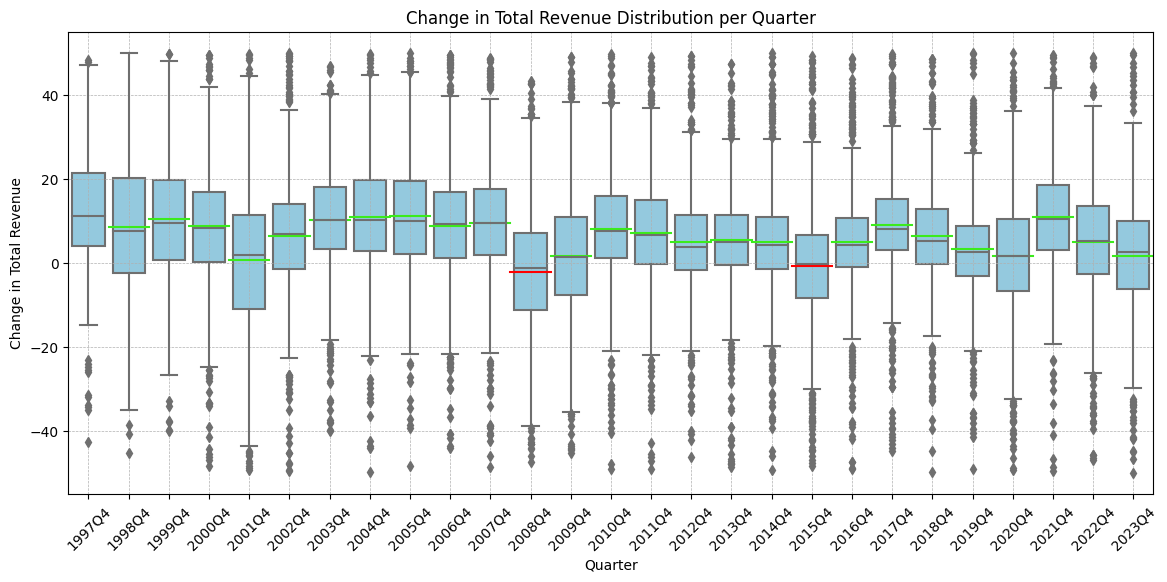

In [ ]:

income_statements_for_viz['Quarter'] = income_statements_for_viz['EffectiveDate'].dt.to_period('Q').astype(str)

plt.figure(figsize=(14, 6))
sns.boxplot(x='Quarter', y='RevenuePctChange', data=income_statements_for_viz, color='skyblue', whis=1.5)


plt.title('Change in Total Revenue Distribution per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Change in Total Revenue')
plt.xticks(rotation=45)

for i, quarter in enumerate(income_statements_for_viz['Quarter'].unique()):
    mean_value = income_statements_for_viz[income_statements_for_viz['Quarter'] == quarter]['RevenuePctChange'].mean()
    if i != 0:
        plt.plot([i - 0.5, i + 0.5], [mean_value, mean_value], color='#3beb1c' if mean_value > 0 else 'red')
    
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
cash_flow = query_stock_data(table="Cash_Flow", ticker = "all_stocks", start_date = "1996-01-01", end_date = "2024-01-01")

cash_flow.describe()


,Investments,NetIncome,BeginPeriodCashFlow,EndPeriodCashFlow,ChangeInCash,ChangeToInventory,FreeCashFlow,CapitalExpenditures
count,28617.00000000,79032.00000000,69616.00000000,70525.00000000,72539.00000000,57122.00000000,70497.00000000,80271.00000000
mean,-37732861350.72314453,2339938051.17148876,9447152886.50231934,20553688683.78673553,-4789624794.68937969,-11719571.03665661,1461500167.35873270,72399424877.34858704
std,6180399199752.73046875,104500892762.04258728,249856565232.64077759,1583287847466.61083984,1275846880750.11376953,82408707438.31732178,93876775511.29743958,19683127583162.00390625
min,-1045406683470800.00000000,-6308429000000.00000000,-31606870000.00000000,-97760998638.88000488,-343124279518400.00000000,-14569952047000.00000000,-4843834000000.00000000,0.00000000
25%,-132200000.00000000,19599999.75000000,106439750.00000000,98700000.00000000,-62582000.00000000,-30016250.00000000,-3000000.00000000,14795000.00000000
50%,-10000000.00000000,86000000.00000000,396000000.00000000,391000000.00000000,1800000.00000000,0.00000000,77000000.00000000,52122000.00000000
75%,8273000.00000000,265652000.00000000,1322000000.00000000,1320000000.00000000,86370000.00000000,14000000.00000000,302997000.00000000,181000000.00000000
max,5835906000000.00000000,10487825000000.00000000,15497345000000.00000000,297584093953000.00000000,5065000000000.00000000,2826563649000.00000000,9441880000000.00000000,5576571234771700.00000000


# Check if price data looks alright 

In [1]:
def plot_pice_data(ticker, start_date, end_date):
    df = query_stock_data(table="Price_Data", ticker=ticker, start_date=start_date, end_date=end_date)
    print(df.head())
    fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

    fig.update_layout(title='NVDA Stock Prices', xaxis_title='Date', yaxis_title='Price')
    fig.show()


plot_pice_data(ticker="hwm", start_date="1996-01-01", end_date="2024-01-01")

NameError: name 'query_stock_data' is not defined

In [ ]:
def plot_volume_data(ticker, start_date, end_date):
    df = query_stock_data(table="Price_Data", ticker=ticker, start_date=start_date, end_date=end_date)
    print(df.head())
    fig = go.Figure(data=[go.Bar(x=df['Date'], y=df['Volume'])])
    fig.update_layout(title='NVDA Stock Volume', xaxis_title='Date', yaxis_title='Volume', height=700)
    fig.show()


plot_volume_data(ticker="NVDA", start_date="2020-01-01", end_date="2024-01-01")

  Ticker                 Date       Open       High        Low      Close  \
0   NVDA  2020-01-02 00:00:00 5.94421919 5.97310000 5.89367776 5.97310000   
1   NVDA  2020-01-03 00:00:00 5.85334964 5.92131921 5.82845237 5.87750000   
2   NVDA  2020-01-06 00:00:00 5.78418588 5.90742847 5.75804351 5.90220000   
3   NVDA  2020-01-07 00:00:00 5.93052774 6.01941096 5.88546369 5.97360000   
4   NVDA  2020-01-08 00:00:00 5.96936371 6.02612943 5.92925424 5.98480000   

   Adjusted_Close  Adjusted_Scalar           Volume  
0      5.97310000       0.02489725 5917548.20311700  
1      5.87750000       0.02489728 5123170.24206803  
2      5.90220000       0.02489749 6545861.89888383  
3      5.97360000       0.02489726 7947349.26860001  
4      5.98480000       0.02489725 6902529.34399534  


## Create some features below here, and explore options

In [ ]:
start_date = "2016-01-01"
end_date   = "2024-01-01"
 
conn = sqlite3.connect("../Data/EOD_financial_data.db")
cursor = conn.cursor()

spy_df, stock_tickers = load_SPY_components()
# stock_tickers = ["NVDA", "AMZN", "MSFT","NSI", "AAPL", "VAT" ,"BAC"]
stock_tickers = ["NVDA", "AMZN"]
# stock_tickers = stock_tickers[:10]

ticker = stock_tickers[0]

print("Ticker: ", ticker)
price_df = query_stock_data(table="Price_Data", ticker=ticker, start_date = start_date, end_date = end_date)
income_statement_df = query_stock_data(table="Income_Statements", ticker=ticker, start_date = start_date, end_date = end_date)
balance_sheet_df = query_stock_data(table="Balance_Sheets", ticker=ticker, start_date = start_date, end_date = end_date)
earnings_df = query_stock_data(table="Earnings", ticker=ticker, start_date = start_date, end_date = end_date)

financial_ratios_df = price_df[["Ticker", "Date", "Close", "Adjusted_Scalar"]].copy()
financial_ratios_df["Date"] = pd.to_datetime(financial_ratios_df["Date"])

earnings_df["Date"] = pd.to_datetime(earnings_df["EffectiveDate"])
income_statement_df["Date"] = pd.to_datetime(income_statement_df["EffectiveDate"])
balance_sheet_df["Date"] = pd.to_datetime(balance_sheet_df["EffectiveDate"])

financial_ratios_df = pd.merge(financial_ratios_df, earnings_df[["Date", "EPSActual"]], on ="Date", how="left")
financial_ratios_df = pd.merge(financial_ratios_df, income_statement_df[["Date", "NetIncome", "TotalRevenue"]], on ="Date", how="left")
financial_ratios_df = pd.merge(financial_ratios_df, balance_sheet_df[["Date", "TotalAssets", "TotalLiabilities", "OutstandingShares"]], on ="Date", how="left")

financial_ratios_df = financial_ratios_df.fillna(method='ffill')

financial_ratios_df["P/E Ratio"] = financial_ratios_df["Close"] / financial_ratios_df["EPSActual"]
financial_ratios_df["P/S Ratio"] = financial_ratios_df["Close"] / (financial_ratios_df["TotalRevenue"] / financial_ratios_df["OutstandingShares"])
financial_ratios_df["P/B Ratio"] = financial_ratios_df["Close"] / ((financial_ratios_df["TotalAssets"] - financial_ratios_df["TotalLiabilities"]) / financial_ratios_df["OutstandingShares"])
        
financial_ratios_df[["P/E Ratio", "P/S Ratio", "P/B Ratio"]] = financial_ratios_df[["P/E Ratio", "P/S Ratio", "P/B Ratio"]].fillna(0)

financial_ratios_df = financial_ratios_df[["Date", "Ticker", "P/E Ratio", "P/S Ratio", "P/B Ratio"]]
financial_ratios_df

Ticker:  NVDA


C:\Users\emilh\AppData\Local\Temp\ipykernel_25292\95960914.py:35: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,Date,Ticker,P/E Ratio,P/S Ratio,P/B Ratio
0,2016-01-04,NVDA,0.00000000,0.00000000,0.00000000
1,2016-01-05,NVDA,0.00000000,0.00000000,0.00000000
2,2016-01-06,NVDA,0.00000000,0.00000000,0.00000000
3,2016-01-07,NVDA,0.00000000,0.00000000,0.00000000
4,2016-01-08,NVDA,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...
2007,2023-12-22,NVDA,121.44154229,67.19416832,36.60178356
2008,2023-12-26,NVDA,122.55820896,67.81202517,36.93834048
2009,2023-12-27,NVDA,122.90149254,68.00196556,37.04180418
2010,2023-12-28,NVDA,123.16268657,68.14648543,37.12052656


# Testing edge based features